In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
import candel

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits


%load_ext autoreload
%autoreload 2

In [21]:
d = np.genfromtxt("/Users/rstiskalek/Projects/CANDEL/data/SDSS/SDSS_PV_public.dat", names=True)

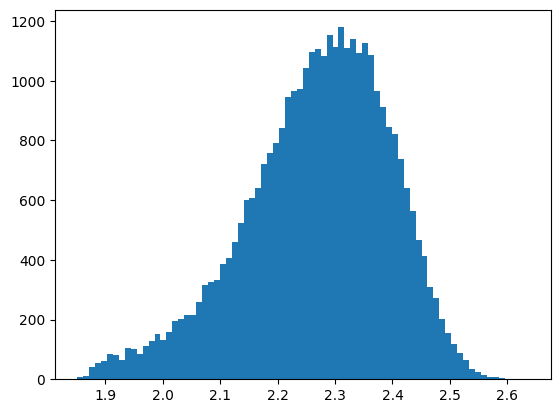

In [29]:
plt.figure()
# plt.hist(d["i"], bins="auto")
plt.hist(d["s"], bins="auto")
plt.show()

In [30]:
d.dtype.names

('PGC',
 'coords',
 'objid',
 'specObjId',
 'plate',
 'RA',
 'Dec',
 'l',
 'b',
 'deVMag_g',
 'deVMagErr_g',
 'deVMag_r',
 'deVMagErr_r',
 'deVRad_r',
 'deVRadErr_r',
 'deVAB_r',
 'deVABErr_r',
 'extinction_g',
 'extinction_r',
 'kcor_r',
 'kcor_g',
 'absmag_r',
 'zhelio',
 'zhelioerr',
 'zcmb',
 'SIGMA_STARS',
 'SIGMA_STARS_ERR',
 'IDgroupT17',
 'NgroupT17',
 'zcmb_group',
 'M',
 'in_mask',
 'nbar',
 'r',
 'er',
 'i',
 'ei',
 's',
 'es',
 'Sn',
 'logdist',
 'logdist_err',
 'logdist_alpha',
 'logdist_corr',
 'logdist_corr_err',
 'logdist_corr_alpha')

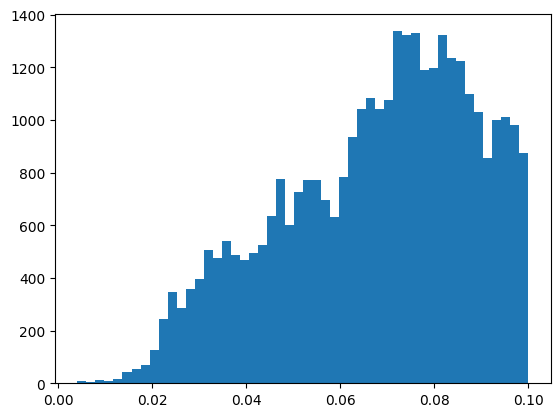

In [24]:
plt.figure()
plt.hist(d["zcmb"], bins="auto")
plt.show()

In [2]:
d_fp = np.genfromtxt("/Users/rstiskalek/Projects/CANDEL/data/SDSS/galaxies_all_primary_n_Khaled_Said.csv", names=True, delimiter=",")
d_nsa = fits.open("/Users/rstiskalek/Projects/CANDEL/data/SDSS/nsa_v1_0_1.fits")[1].data

d_fp = d_fp[d_fp["redshift"] < 0.06]
d_nsa = d_nsa[d_nsa['Z'] < 0.06]


In [8]:
def crossmatch_fp_nsa(d_fp, d_nsa, tolerance=1*u.arcsec, delta_v_kms=1, plot=True):
    ztol = delta_v_kms / candel.SPEED_OF_LIGHT
    print(f"Angular match tolerance: {tolerance.to(u.arcsec)}")
    print(f"Redshift match tolerance: Δz < {ztol:.2e} (i.e., {delta_v_kms} km/s)")

    print("Creating SkyCoord objects...")
    coords_fp = SkyCoord(ra=d_fp["ra"] * u.deg, dec=d_fp["dec"] * u.deg)
    coords_nsa = SkyCoord(ra=d_nsa["RA"] * u.deg, dec=d_nsa["DEC"] * u.deg)

    print("Matching on sky coordinates...")
    idx, sep2d, _ = coords_fp.match_to_catalog_sky(coords_nsa)
    matched_mask = sep2d < tolerance
    n_matched = np.count_nonzero(matched_mask)
    print(f"{n_matched} matches found within {tolerance.to(u.arcsec)}")

    if n_matched == 0:
        print("No angular matches found.")
        return np.empty(0)

    # Extract matched entries
    fp_idx = np.where(matched_mask)[0]
    nsa_idx = idx[matched_mask]
    fp_matched = d_fp[fp_idx]
    nsa_matched = d_nsa[nsa_idx]

    # Build structured array
    print("Building matched array...")
    fp_dtype = [(f"{name}_FP", fp_matched.dtype[name]) for name in fp_matched.dtype.names]
    nsa_dtype = [(f"{name}_NSA", nsa_matched.dtype[name]) for name in nsa_matched.dtype.names]
    sep_dtype = [("sep_arcsec", np.float64)]
    dtype_combined = fp_dtype + nsa_dtype + sep_dtype

    matched_array = np.empty(len(fp_matched), dtype=dtype_combined)

    for name in fp_matched.dtype.names:
        matched_array[f"{name}_FP"] = fp_matched[name]
    for name in nsa_matched.dtype.names:
        matched_array[f"{name}_NSA"] = nsa_matched[name]
    matched_array["sep_arcsec"] = sep2d[matched_mask].arcsec

    # Redshift filtering
    dz = matched_array["redshift_FP"] - matched_array["Z_NSA"]
    zcut_mask = np.abs(dz) < ztol
    n_final = np.count_nonzero(zcut_mask)
    print(f"{n_final} matches remain after redshift filtering (Δz < {ztol:.2e})")

    matched_array = matched_array[zcut_mask]

    if plot:
        plt.figure()
        plt.hist(dz[zcut_mask] * candel.SPEED_OF_LIGHT, bins=50, log=True)
        plt.xlabel(r"$c\Delta z$ [km/s]")
        plt.tight_layout()
        plt.show()

        plt.figure()
        plt.hist(matched_array["sep_arcsec"], bins="auto", histtype="step")
        plt.xlim(0)
        plt.xlabel("Angular separation [arcsec]")
        plt.show()


    return matched_array

Angular match tolerance: 1.0 arcsec
Redshift match tolerance: Δz < 3.34e-06 (i.e., 1 km/s)
Creating SkyCoord objects...
Matching on sky coordinates...
127544 matches found within 1.0 arcsec
Building matched array...
126889 matches remain after redshift filtering (Δz < 3.34e-06)


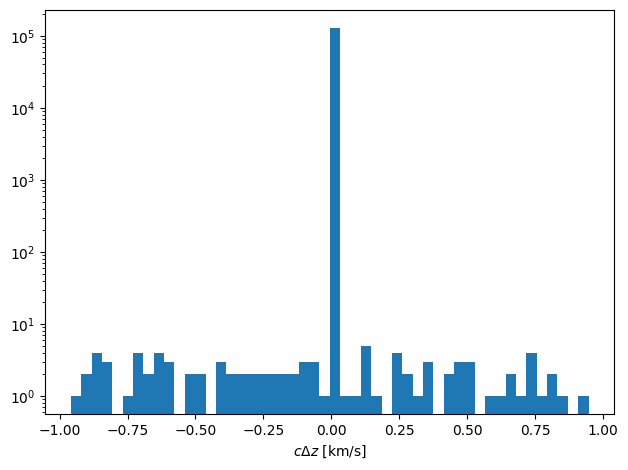

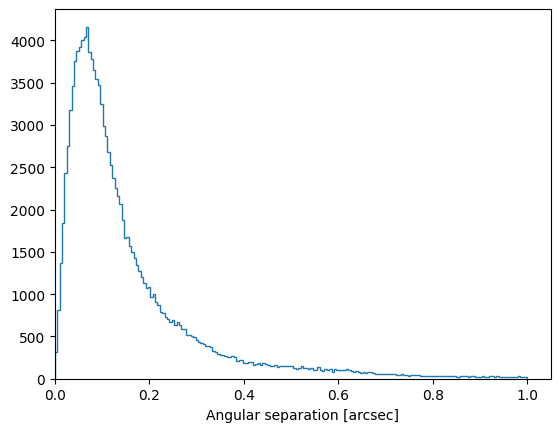

In [12]:
matched = crossmatch_fp_nsa(d_fp, d_nsa, tolerance=1*u.arcsec, delta_v_kms=1, plot=True)

In [14]:
matched.dtype.names

('bestObjID_FP',
 'specobjid_FP',
 'ra_FP',
 'dec_FP',
 'class_FP',
 'survey_FP',
 'instrument_FP',
 'legacy_target1_FP',
 'legacy_target2_FP',
 'sdssPrimary_FP',
 'plate_FP',
 'mjd_FP',
 'fiberid_FP',
 'redshift_FP',
 'zErr_FP',
 'veldisp_FP',
 'veldispErr_FP',
 'snMedian_g_FP',
 'snMedian_r_FP',
 'snMedian_i_FP',
 'snMedian_FP',
 'expTime_FP',
 'seeing20_FP',
 'seeing50_FP',
 'seeing80_FP',
 'Column1_FP',
 'Column2_FP',
 'sigmaStars_FP',
 'sigmaStarsErr_FP',
 'IAUNAME_NSA',
 'SUBDIR_NSA',
 'RA_NSA',
 'DEC_NSA',
 'ISDSS_NSA',
 'INED_NSA',
 'ISIXDF_NSA',
 'IALFALFA_NSA',
 'IZCAT_NSA',
 'ITWODF_NSA',
 'MAG_NSA',
 'Z_NSA',
 'ZSRC_NSA',
 'SIZE_NSA',
 'RUN_NSA',
 'CAMCOL_NSA',
 'FIELD_NSA',
 'RERUN_NSA',
 'XPOS_NSA',
 'YPOS_NSA',
 'NSAID_NSA',
 'ZDIST_NSA',
 'SERSIC_NMGY_NSA',
 'SERSIC_NMGY_IVAR_NSA',
 'SERSIC_OK_NSA',
 'SERSIC_RNMGY_NSA',
 'SERSIC_ABSMAG_NSA',
 'SERSIC_AMIVAR_NSA',
 'EXTINCTION_NSA',
 'SERSIC_KCORRECT_NSA',
 'SERSIC_KCOEFF_NSA',
 'SERSIC_MTOL_NSA',
 'SERSIC_B300_NSA',
 'S

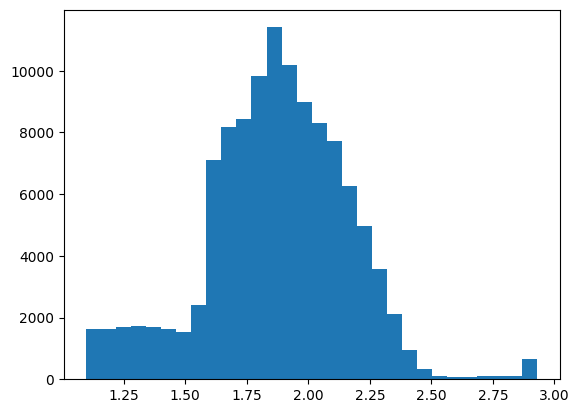

In [18]:
m = matched["veldisp_FP"] > 0

plt.figure()
plt.hist(np.log10(matched["veldisp_FP"][m]), bins=30)
plt.show()